In [1]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
import optax

In [4]:
%config Completer.use_jedi = False

## Tutorial

### Fit a linear regression

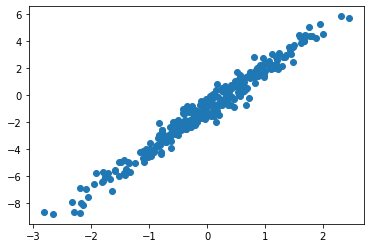

In [5]:
import numpy as np
import matplotlib.pyplot as plt

n = 300
xs = np.random.normal(size=(n,))
noise = np.random.normal(scale=0.5, size=(n,))
ys = xs * 3 - 1 + noise

plt.scatter(xs, ys);

In [6]:
# theta = [w, b] - model parameters
def model(theta, x):
  """Computes wx + b on a batch of input x."""
  w, b = theta
  return w * x + b

Loss function is the sum of squared errors, $ L = \Sigma (y - y_{pred})^2$

In [7]:
def loss_fn(theta, x, y):
  prediction = model(theta, x)
  return jnp.mean((prediction-y)**2)

In [8]:
loss_fn((3,1), 0, 4)

Array(9., dtype=float32)

In [9]:
loss_fn((3,1), xs, ys)

Array(4.2634077, dtype=float32)

Use gradient discend to find the optimal parameters, 
$$
\theta_{updated}=\theta + \lambda\nabla_{\theta}L(\theta, x, y)
$$
where $\lambda$ is learning rate.

In [10]:
@jax.jit
def update(theta, x, y, lr=0.1):
  return theta - lr * grad(loss_fn)(theta, x, y)

In [11]:
theta = jnp.array([1., 1.])
theta

Array([1., 1.], dtype=float32)

In [12]:
grad(loss_fn)(theta, 1., 1.)

Array([2., 2.], dtype=float32)

In [13]:
grad(loss_fn)(theta, 2., -1.)

Array([16.,  8.], dtype=float32)

Gradient returns the average gradient for vectors of variables.

In [14]:
grad(loss_fn)(theta, jnp.array([1., 2.]), jnp.array([1., -1.]))

Array([9., 5.], dtype=float32)

In [15]:
# initial parateters
theta = jnp.array([1., 1.])
theta
n_iterations = 200
lr = .1
for i in range(n_iterations):
    theta = update(theta, xs, ys, lr=lr)
theta

Array([ 2.995783 , -1.0006436], dtype=float32)

### Compute greeks of Black-Scholes option prices with jax.grad

In [16]:
#@jax.jit
def bs_call(S, X, T, sig, r):
    d1 = (jnp.log(S/X) + (r + .5 * sig**2) * T)/(jnp.sqrt(T) * sig)
    print(f'd1 = {d1}')
    d2 = d1 - jnp.sqrt(T) * sig
    print(f'd2 = {d2}')
    c = S * jax.scipy.stats.norm.cdf(d1) - X * jnp.exp(-r*T)* jax.scipy.stats.norm.cdf(d2)
    print(f'delta = {jax.scipy.stats.norm.cdf(d1)}')
    return c

In [17]:
S=60.
X=65.
r=.08
sig=.30
T=.25
bs_call(S, X, T, sig, r)

d1 = -0.3252846896648407
d2 = -0.4752846956253052
delta = 0.3724828064441681


Array(2.1333694, dtype=float32)

In [18]:
# pars = [S, X, T, sig, r]
def euro_call(pars):
    S, X, T, sig, r = pars
    c = bs_call(S, X, T, sig, r)
    return c

In [19]:
euro_call([S, X, T, sig, r])

d1 = -0.3252846896648407
d2 = -0.4752846956253052
delta = 0.3724828064441681


Array(2.1333694, dtype=float32)

In [20]:
pars = [S, X, T, sig, r]
jax.grad(euro_call)(pars)

d1 = Traced<ConcreteArray(-0.3252846896648407, dtype=float32, weak_type=True)>with<JVPTrace(level=2/0)> with
  primal = Array(-0.3252847, dtype=float32, weak_type=True)
  tangent = Traced<ShapedArray(float32[], weak_type=True)>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[], weak_type=True), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7f86775d1930>, in_tracers=(Traced<ShapedArray(float32[], weak_type=True):JaxprTrace(level=1/0)>, Traced<ShapedArray(float32[], weak_type=True):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.15000000596046448, dtype=float32, weak_type=True):JaxprTrace(level=1/0)>, Traced<ConcreteArray(-0.048792704939842224, dtype=float32, weak_type=True):JaxprTrace(level=1/0)>, Traced<ConcreteArray(44.44444274902344, dtype=float32, weak_type=True):JaxprTrace(level=1/0)>), out_tracer_refs=[<weakref at 0x7f8677c596c0; to 'JaxprTracer' at 0x7f8677c59670>], out_avals=[ShapedArray(float32[], weak_type=True)], primitive=pjit, params={'jaxpr': 

[Array(0.3724828, dtype=float32, weak_type=True),
 Array(-0.31100923, dtype=float32, weak_type=True),
 Array(8.428175, dtype=float32, weak_type=True),
 Array(11.351544, dtype=float32, weak_type=True),
 Array(5.0539, dtype=float32, weak_type=True)]

In [21]:
np.sqrt(4) + 2

4.0

### Random numbers

In [22]:
key = jax.random.PRNGKey(42)
print(random.normal(key, shape=(5,)))
print(random.normal(key, shape=(5,)))

[ 0.6122652  1.1225883 -0.8544134 -0.8127325 -0.890405 ]
[ 0.6122652  1.1225883 -0.8544134 -0.8127325 -0.890405 ]


In [23]:
# never reuse a key
key = jax.random.PRNGKey(42)
key, subkey = random.split(key)
print(random.normal(subkey, shape=(5,)))
key, subkey = random.split(key)
print(random.normal(subkey, shape=(5,)))

[-0.55338794  0.944283   -0.74176395 -0.5769758   1.1251862 ]
[-0.32761317 -0.4066346   1.2469071   1.1900425   1.100263  ]


## Common models

### Linear model

$y = wx + b$

Generate observed values

In [24]:
key = jax.random.PRNGKey(212)
w = jnp.array([1., -1., 3., 5., -2.])
b = 2
theta_true = jnp.append(w, b)
print(theta_true)

[ 1. -1.  3.  5. -2.  2.]


In [25]:
@jax.jit
def model(theta, x):
    w = theta[:-1]
    b = theta[-1]
    y = jnp.dot(w, x) + b
    return y

model_vmap = jax.vmap(model, in_axes=[None, 1])

In [26]:
model(theta_true, jnp.array([1, 2, 3, 4, 5]))

Array(20., dtype=float32)

In [27]:
np.array([1, 2, 3, 4, 5, 1, 2, 3, 4, 5]).reshape(5, 2)

array([[1, 2],
       [3, 4],
       [5, 1],
       [2, 3],
       [4, 5]])

In [28]:
#model_vmap(theta, np.array([1, 2, 3, 4, 5, 1, 2, 3, 4, 5]).reshape(5, 2))

In [29]:
n_obs = 50
x_observed = jax.random.normal(key, shape=(5,n_obs))
print(x_observed.shape)
print(jnp.sum(x_observed, axis=1))


(5, 50)
[-1.9834332  3.693717  -2.6479702  1.790731  12.152575 ]


In [30]:
# observations - model plus some noise
y_observed = model(theta_true, x_observed) + jax.random.normal(key, shape=(n_obs,))
print(y_observed)

[  5.061532     2.4697185   -3.1689067   -7.6509895   -3.878571
  11.230026     1.4037006    4.2314587    9.178272     5.9207597
  -1.3583989   -4.3980184    5.3401203    0.41575944  -1.9732022
  -8.83993      6.2698207   -2.5513077    6.314845    -8.689926
  -1.7106991   -5.669702     8.188997    10.294529     5.785759
  -5.8465557   17.606495     5.477191    11.000769     7.3086863
  -3.7401242    6.787878     8.182899     1.5911278    1.0267415
   4.3348236   -5.980621   -11.129906    -4.772352    -3.095614
  -0.26369235  -5.845175    -2.9242475    3.4858134   11.435972
  11.133466    -4.316735     0.92751443  -5.489374    -8.450031  ]


Text(0.5, 1.0, 'Noisy observations vs underlying model')

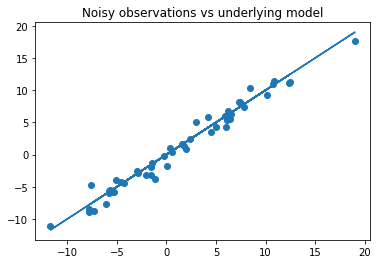

In [31]:
plt.scatter(model(theta_true, x_observed), y_observed)
plt.plot(model(theta_true, x_observed), model(theta_true, x_observed))
plt.title('Noisy observations vs underlying model')

In [32]:
%timeit model(theta_true, x_observed)

7.6 µs ± 137 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [33]:
y_observed = model_vmap(theta_true, x_observed)
print(y_observed)

[ 2.9883358e+00  2.3349292e+00 -1.5650349e+00 -6.1130486e+00
 -5.0836453e+00  1.2472522e+01  1.8045750e+00  5.0270219e+00
  1.0129258e+01  5.9141598e+00 -1.4724889e+00 -4.2724571e+00
  6.0810962e+00  5.5440164e-01 -1.5313129e+00 -7.7776632e+00
  6.5286217e+00 -2.9492378e+00  6.2737894e+00 -7.3210154e+00
  1.4329433e-02 -5.8055058e+00  7.4530363e+00  8.3956413e+00
  4.1605120e+00 -5.3344989e+00  1.8990660e+01  6.3681188e+00
  1.0795193e+01  7.7783060e+00 -1.1883299e+00  6.2501445e+00
  7.3560805e+00  1.6167390e+00  3.5765314e-01  6.0111747e+00
 -5.7826834e+00 -1.1694789e+01 -7.5610752e+00 -2.0660710e+00
 -2.2288561e-01 -5.6120420e+00 -2.8691711e+00  4.5343022e+00
  1.0853861e+01  1.2338906e+01 -4.6002135e+00  1.9807792e+00
 -5.6962886e+00 -7.8172445e+00]


In [34]:
# slower tham model?
%timeit model_vmap(theta_true, x_observed)

717 µs ± 12.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [35]:
# loss function - mean squared error
def loss_fn(theta, x, y):
  prediction = model(theta, x)
  return jnp.mean((prediction-y)**2)

In [36]:
# update step
@jax.jit
def update(theta, x, y, lr=0.01):
  return theta - lr * grad(loss_fn)(theta, x, y)

In [37]:
# initial parateters
theta = jnp.array([1., 1., 1., 1., 1., 1.])
theta
n_iterations = 1000
lr = .01
for i in range(n_iterations):
    theta = update(theta, x_observed, y_observed, lr=lr)
print(theta)
print(theta_true)


[ 1.0000066 -0.9999936  2.9999955  5.0000114 -1.9999946  1.999995 ]
[ 1. -1.  3.  5. -2.  2.]


### Logistic regression classifier

First, we create data using bivariate normal distribution.

In [38]:
class1 = random.multivariate_normal(key,
                           mean=jnp.array([1, 1]),
                           cov=.5*np.array([1, .5, .5, 1]).reshape(2,2),
                          shape=[100,])
class1[:5,:]

Array([[ 2.2076726 ,  0.6332452 ],
       [ 0.53972983, -0.51073563],
       [ 1.6998711 ,  1.4444137 ],
       [-0.05809402,  1.330411  ],
       [ 0.23326337,  0.6060622 ]], dtype=float32)

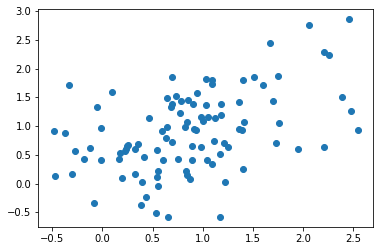

In [39]:
plt.scatter(class1[:, 0], class1[:, 1])

In [40]:
key, subkey = random.split(key)
class2 = random.multivariate_normal(key,
                           mean=jnp.array([3, 3]),
                           cov=.25*np.array([1, .7, .7, 1]).reshape(2,2),
                          shape=[100,])
class2[:5,:]

Array([[3.4657753, 3.195562 ],
       [2.5691884, 3.163034 ],
       [2.985951 , 2.7663414],
       [2.1083503, 2.027696 ],
       [2.6487987, 2.8870454]], dtype=float32)

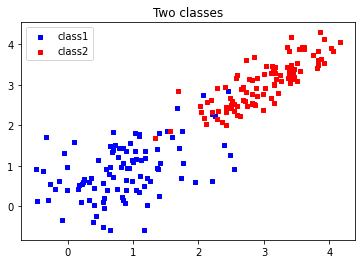

In [41]:

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(class1[:, 0], class1[:, 1], s=10, c='b', marker="s", label='class1')
ax1.scatter(class2[:, 0], class2[:, 1], s=10, c='r', marker="s", label='class2')
plt.title('Two classes')
plt.legend()


Logistic regression models the probability of belonging to $class1$ as
$$
p = \frac{1}{1+e^{-(wx + b)}},
$$
where, in our case, $w = (w_1, w_2), x = (x_1, x_2)$, and $b$ is a scalar.
The loss function at $p_k, y_k$ is defined as 

$$
\left\{
\begin{array}{l}
      -log(p_k),\ if\  y_k = 1\ \    (class 1),\\
      -log(1-p_k),\ if\  y_k=0 \ \    (class 2).
      \end{array}
  \right.
$$
Combining, we get cross entropy loss function

$$
L = -\Sigma_1^N (y_k\log(p_k) + (1-y_k)log(1-p_k)).
$$

In [42]:
# implement functions
@jax.jit
def sigmoid(t):
    return 1/(1 + jnp.exp(-t))

@jax.jit
def model(theta, x):
    w = theta[:-1]
    b = theta[-1]
    t = jnp.dot(w, x) + b
    p = sigmoid(t)
    return p

# loss function - cross entropy
def loss_fn(theta, x, y):
  p = model(theta, x)
#  print(theta.dtype)
#  print(y.dtype)
# print(y*(jnp.log(p) + (1-y)*jnp.log(1-p)))    
  return -jnp.mean(y*jnp.log(p) + (1-y)*jnp.log(1-p))

# update step
@jax.jit
def update(theta, x, y, lr=0.01):
  return theta - lr * grad(loss_fn)(theta, x, y)

In [43]:
class1[:5, :]

Array([[ 2.2076726 ,  0.6332452 ],
       [ 0.53972983, -0.51073563],
       [ 1.6998711 ,  1.4444137 ],
       [-0.05809402,  1.330411  ],
       [ 0.23326337,  0.6060622 ]], dtype=float32)

In [44]:
theta = np.array([1., 1., 1.])
model(theta, class1[:5, :].transpose())

Array([0.97897756, 0.73672086, 0.98439276, 0.9065582 , 0.8628689 ],      dtype=float32)

In [47]:
#loss_fn(theta, data[:,:-1].transpose(), lbl)

In [48]:
# alternative cross entropy function
from sklearn.metrics import log_loss
lbl = jnp.concatenate((jnp.ones(shape=(len(class1),)), jnp.zeros(shape=(len(class2),))))
data = jnp.column_stack((jnp.row_stack((class1, class2)), lbl))
log_loss(lbl, model(theta, data[:,:-1].transpose()))

3.5610647238290882

In [49]:
def BinaryCrossEntropy(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
    term_0 = (1-y_true) * np.log(1-y_pred + 1e-7)
    term_1 = y_true * np.log(y_pred + 1e-7)
    return -np.mean(term_0+term_1, axis=0)

In [50]:
BinaryCrossEntropy(lbl, model(theta, data[:,:-1].transpose()))

Array(3.5609667, dtype=float32)

In [51]:
update(theta, class1[:, :].transpose(), jnp.ones(shape=(len(class1),)))

Array([1.0003867, 1.0003953, 1.0009131], dtype=float32)

In [52]:
#input data
lbl = jnp.concatenate((jnp.ones(shape=(len(class1),)), jnp.zeros(shape=(len(class2),))))
data = jnp.column_stack((jnp.row_stack((class1, class2)), lbl))
print(data.shape)
print(data[:5, :])
print(data[-5:, :])
# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    data[:,:-1], 
    data[:,-1], 
    test_size=0.3, random_state=212
)

(200, 3)
[[ 2.2076726   0.6332452   1.        ]
 [ 0.53972983 -0.51073563  1.        ]
 [ 1.6998711   1.4444137   1.        ]
 [-0.05809402  1.330411    1.        ]
 [ 0.23326337  0.6060622   1.        ]]
[[3.8604279 4.300192  0.       ]
 [3.019225  2.9260416 0.       ]
 [3.8114538 3.4090698 0.       ]
 [3.5774093 3.9309077 0.       ]
 [1.5694052 1.8653797 0.       ]]


In [53]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_test.sum())

(140, 2)
(60, 2)
(140,)
(60,)
30.0


In [54]:
# fit parameters
# initial parateters
theta = jnp.array([1., 1., 1.])
n_iterations = 1000
lr = .1
for i in range(n_iterations):
    #print(theta)
    theta = update(theta, X_train.transpose(), y_train, lr=lr)
    #print(loss_fn(theta, X_train.transpose(), y_train))
print(theta)

[-1.5511609 -1.0677812  5.084245 ]


In [55]:
jnp.column_stack((model(theta, X_train.transpose()), y_train))

Array([[0.20930234, 0.        ],
       [0.9831487 , 1.        ],
       [0.00866498, 0.        ],
       [0.02403557, 0.        ],
       [0.9526377 , 1.        ],
       [0.02701292, 0.        ],
       [0.25623667, 1.        ],
       [0.07659077, 0.        ],
       [0.11618116, 0.        ],
       [0.06938237, 0.        ],
       [0.20087484, 0.        ],
       [0.990144  , 1.        ],
       [0.08447833, 0.        ],
       [0.07320185, 0.        ],
       [0.4130719 , 0.        ],
       [0.8133388 , 1.        ],
       [0.01310753, 0.        ],
       [0.9780342 , 1.        ],
       [0.85499614, 1.        ],
       [0.01387923, 0.        ],
       [0.17093155, 0.        ],
       [0.00493845, 0.        ],
       [0.02507334, 0.        ],
       [0.03229025, 0.        ],
       [0.979902  , 1.        ],
       [0.9336192 , 1.        ],
       [0.00937117, 0.        ],
       [0.00810273, 0.        ],
       [0.20283605, 0.        ],
       [0.18599209, 0.        ],
       [0.

In [56]:
from usefulml.ml_utils import  binary_classification_metrics
binary_classification_metrics(y_train,
                              jnp.round(model(theta, X_train.transpose()), 0),
                              model(theta, X_train.transpose()),
                              4
                             )

,Prevalence,Sensitivity,Specificity,Accuracy,Precision,F1,FPR,MCC,AUC,LogLoss
0,0.5,0.9,1.0,0.95,1.0,0.9474,0.0,0.9045,0.9945,0.1431


In [57]:
# now for test data
binary_classification_metrics(y_test,
                              jnp.round(model(theta, X_test.transpose()), 0),
                              model(theta, X_test.transpose()),
                              4
                             )

,Prevalence,Sensitivity,Specificity,Accuracy,Precision,F1,FPR,MCC,AUC,LogLoss
0,0.5,1.0,0.9333,0.9667,0.9375,0.9677,0.0667,0.9354,0.9956,0.161


Draw a decision boundary using cutoff of 0.5
$$
w_1x_1 + w_2x_2 + b = 0, \newline
x_2 = -\frac{w_1}{w_2}x_1 - \frac{b}{w_2}
$$ 

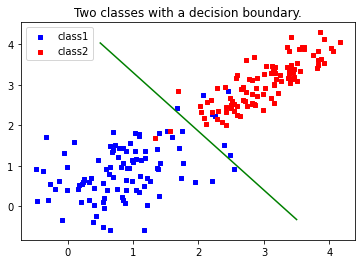

In [58]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(class1[:, 0], class1[:, 1], s=10, c='b', marker="s", label='class1')
ax1.scatter(class2[:, 0], class2[:, 1], s=10, c='r', marker="s", label='class2')
x1 = jnp.linspace(.5, 3.5, 50)
x2 = ( -theta[0]*x1 - theta[2])/theta[1]
ax1.plot(x1, x2, c='g')
plt.title('Two classes with a decision boundary.')
plt.legend()


In [59]:
theta[2]

Array(5.084245, dtype=float32)

### Fully connected neural network.

$x \in R^n$, an input vector, transformed to a vector of length $m$ via 
$$
x = xW + b, \newline
x = activation\_function(x),
$$
where $W \in R^{n\times m}, b \in R^m$.
This represents one layer of the network. The final layer transforms to the dimension of the output, and in case of classsification - sigmoid.


In [60]:
# A link to the data is availailable in the following blog post
# https://scipython.com/blog/a-shallow-neural-network-for-simple-nonlinear-classification/
df = pd.read_csv('../non_linear_class_example/labeled_points.txt', sep=' ',
                usecols=[1,3,5], names=['x1', 'x2', 'label'])

In [61]:
df.head()

,x1,x2,label
0,0.50873,0.08490,1
1,0.96767,0.96752,1
2,0.72096,0.90628,1
3,0.66071,0.32757,1
4,0.48690,0.58265,0


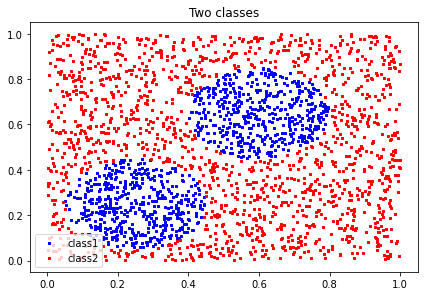

In [62]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
df_cl1 = df[df.label == 0]
df_cl2 = df[df.label == 1]
ax1.scatter(df_cl1.x1, df_cl1.x2, s=5, c='b', marker="s", label='class1')
ax1.scatter(df_cl2.x1, df_cl2.x2, s=5, c='r', marker="s", label='class2')
fig.tight_layout()
plt.title('Two classes')
plt.legend()


In [63]:
# implement functions
@jax.jit
def sigmoid(t):
    return 1/(1 + jnp.exp(-t))

@jax.jit
def tanh(x):
    return jnp.tanh(x)

#@jax.jit
# def model(theta, x):
#     W, b, w_o = theta
#     y = jnp.dot(x, W) + b # input dim = 2, W is 2xN, N - num hidden neurons, b is dim N
#     y = tanh(y)  # vector dim N
#     y = jnp.dot(y, w_o)  # w_o is Nx1, output layer is a scalar
#     p = sigmoid(y)  # map to (0, 1)
#     return p

#2 hidden layers
@jax.jit
def model(theta, x):
    W, b, W1, b1, w_o = theta
    y = jnp.dot(x, W) + b # input dim = 2, W is 2xN, N - num hidden neurons, b is dim N
    y = tanh(y)  # vector dim N
    y = jnp.dot(y, W1) + b1 # input dim = N, W is NxN, N - num hidden neurons, b is dim N
    y = tanh(y)  # vector dim N
    y = jnp.dot(y, w_o)  # w_o is Nx1, output layer is a scalar
    p = sigmoid(y)  # map to (0, 1)
    return p

# loss function - cross entropy
def loss_fn(theta, x, y):
  p = model(theta, x)
  return -jnp.mean(y*jnp.log(p) + (1-y)*jnp.log(1-p))

# update step
# handle the updates
@jax.jit
def update(theta, x, y, lr=0.01):
    W, b, W1, b1, w_o = theta
    gr_W, gr_b, gr_W1, gr_b1, gr_w_o = grad(loss_fn)(theta, x, y)
    return (W - lr * gr_W, b - lr * gr_b, W1 - lr * gr_W1, b1 - lr * gr_b1, w_o - lr * gr_w_o)

In [64]:
# lets see how grad works
x = jnp.array(df[['x1', 'x2']])
y = jnp.array(df['label'])
print(x.shape)
print(y.shape)

(2506, 2)
(2506,)


In [65]:
#first point
print(x[0])
# W dim
input_dim = 2
hidden_dim = 10
#key = jax.random.PRNGKey(42)
#key, subkey = random.split(key)
#print(random.normal(subkey, shape=(5,)))
print('init inputs with random numbers:')
W = jax.random.normal(key, shape=(input_dim, hidden_dim)) * .01
b = jax.random.normal(key, shape=(1, hidden_dim)) * .01
W1 = jax.random.normal(key, shape=(hidden_dim, hidden_dim)) * .01
b1 = jax.random.normal(key, shape=(1, hidden_dim)) * .01
w = jax.random.normal(key, shape=(hidden_dim, 1)) * .01
print('dimensions:')
print('W:', W.shape)
print('b:', b.shape)
print('W1:', W1.shape)
print('b1:', b1.shape)
print('w:', w.shape)
print('model:')
print(model((W, b, W1, b1, w), x[0:10]))
print('loss function:')
print(loss_fn((W, b, W1, b1, w), x[0:10], y[0:10]))
print('gradient dim:')
print(list(map(lambda i: i.shape, grad(loss_fn)((W, b, W1, b1, w), x[0:5], y[0:5]))))

[0.50873 0.0849 ]
init inputs with random numbers:
dimensions:
W: (2, 10)
b: (1, 10)
W1: (10, 10)
b1: (1, 10)
w: (10, 1)
model:
[[0.500121  ]
 [0.5001213 ]
 [0.5001215 ]
 [0.50012106]
 [0.5001215 ]
 [0.50012153]
 [0.50012046]
 [0.5001213 ]
 [0.5001212 ]
 [0.5001213 ]]
loss function:
0.6930502
gradient dim:
[(2, 10), (1, 10), (10, 10), (1, 10), (10, 1)]


In [66]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(
    x, 
    y,
    stratify=y,
    test_size=0.3, random_state=212
)
print(list(map(lambda i: i.shape, (X_train, X_test, y_train, y_test))))
print(y_train.sum(), y_test.sum())

[(1754, 2), (752, 2), (1754,), (752,)]
1051 451


In [67]:
theta = (W, b, W1, b1, w)
print('Initial parameters:')
print(theta)
n_iterations = 100
lr = 1
for i in range(n_iterations):
    #print(theta)
    theta = update(theta, X_train, y_train, lr=lr)
    print(loss_fn(theta, X_train, y_train), loss_fn(theta, X_test, y_test))
print('Calibrated parameters:')
print(theta)

Initial parameters:
(Array([[ 6.9056982e-03,  2.0546889e-02,  3.0855844e-03, -1.9563239e-02,
         1.3135438e-02,  7.3980745e-03,  3.3009914e-03,  5.7546115e-03,
        -5.0278604e-03, -5.0521867e-06],
       [ 1.9147096e-02, -3.0574058e-03,  1.5100390e-03, -6.7560915e-03,
         8.8257054e-03,  3.5839947e-04, -4.3939496e-03,  9.4707329e-03,
         1.2318322e-02, -9.1858662e-04]], dtype=float32), Array([[-0.00263982, -0.00850684, -0.00018801, -0.00092177,  0.00396955,
        -0.00661077,  0.00506398, -0.00301285, -0.01707132,  0.00432915]],      dtype=float32), Array([[-9.67075676e-03, -1.30032785e-02,  7.13126361e-03,
        -3.38842464e-03,  1.83017030e-02, -2.00674706e-03,
         1.07202781e-02,  7.59253418e-03,  3.54917790e-03,
        -1.02124820e-02],
       [ 1.67941265e-02, -4.64424677e-03,  1.69534422e-02,
         1.37889320e-02,  2.57551018e-02,  6.93527795e-03,
         1.18399486e-02,  2.11708825e-02,  1.61819272e-02,
        -4.87724692e-03],
       [-1.231702

In [68]:
# performance metrics
binary_classification_metrics(y_test,
                              jnp.round(model(theta, X_test), 0),
                              model(theta, X_test),
                              4
                             )

/Users/andrei.salomatov/miniconda3/envs/options/lib/python3.10/site-packages/usefulml/ml_utils.py:100: RuntimeWarning: invalid value encountered in scalar divide
  'MCC': [(TP * TN - FP * FN)/((TP + FP) * (FN + TN) * (FP + TN) * (TP + FN))**0.5],


,Prevalence,Sensitivity,Specificity,Accuracy,Precision,F1,FPR,MCC,AUC,LogLoss
0,0.5997,1.0,0.0,0.5997,0.5997,0.7498,1.0,NaN,0.59,0.6731


In [69]:
W + .01 * grad(loss_fn)((W, b, w), x[0:5], y[0:5])[0]

ValueError: not enough values to unpack (expected 5, got 3)

#### The above nn is not performing, let's try using an optimizer

In [70]:
key, w1key, b1key, w2key, b2key, w3key, b3key = jax.random.split(key, 7)
num_input = X_train.shape[1]
num_hidden1 = 16
num_labels = y_train.max() + 1
print('Dimensions are ', num_input, num_hidden1, num_labels)
#num_hidden2 = 1024
params = dict(
    w1 = 1e-2*jax.random.normal(w1key, (num_input, num_hidden1)),
    b1 = 1e-2*jax.random.normal(b1key, (1, num_hidden1)),
#    w2 = 1e-2*jax.random.normal(w2key, (num_hidden1, num_hidden2)),
#    b2 = 1e-2*jax.random.normal(b2key, (1, num_hidden2)),
    w3 = 1e-2*jax.random.normal(w3key, (num_hidden1, num_labels)),
    b3 = 1e-2*jax.random.normal(b3key, (1, num_labels)),
)
for k in params.keys():
    print(f'Dimensions of {k} are ', params[k].shape)

Dimensions are  2 16 2
Dimensions of w1 are  (2, 16)
Dimensions of b1 are  (1, 16)
Dimensions of w3 are  (16, 2)
Dimensions of b3 are  (1, 2)


In [126]:
@jax.jit
def net(params, x):
    x = jax.nn.relu(x@params["w1"] + params["b1"])
#    x = jax.nn.relu(x@params["w2"] + params["b2"])
    x = x@params["w3"] + params["b3"]
#    x = sigmoid(x)
    return x

In [128]:
@jax.jit
def loss(params: optax.Params, batch: jnp.ndarray, labels: jnp.ndarray) -> jnp.ndarray:
  y_hat = net(params, batch)

  # optax also provides a number of common loss functions.
  loss_value = optax.sigmoid_binary_cross_entropy(y_hat, labels).sum(axis=-1)

  return loss_value.mean()

loss(params, X_train, jax.nn.one_hot(y_train, 2))

Array(1.3849089, dtype=float32)

In [97]:
@jax.jit
def xeloss(x, y):
    _elementwise_xeloss = jax.vmap(lambda x, y: -jax.nn.log_softmax(x)[y])
    #print(_elementwise_xeloss(x, y))
    return _elementwise_xeloss(x, y).mean()

In [129]:
print('model:')
print(net(params, x[0:10]))
print('loss function:')
print(xeloss(net(params, x[0:10]), y[0:10]))

model:
[[-0.00094365  0.0135731 ]
 [-0.00072579  0.01329562]
 [-0.00073587  0.01333194]
 [-0.00090673  0.01348859]
 [-0.00082399  0.01343765]
 [-0.00091512  0.0135971 ]
 [-0.0010734   0.01339558]
 [-0.00087602  0.01348371]
 [-0.00081115  0.01339003]
 [-0.00092671  0.01355761]]
loss function:
0.69033426


In [130]:
@jax.jit
def accuracy(x, y):
    return 100*(jnp.argmax(x, 1) == y).mean()
accuracy(net(params, x[0:10]), y[0:10])

Array(70., dtype=float32)

In [131]:
@jax.jit
def lossforward(params, x, y):
    x = net(params, x)
    loss = xeloss(x, y)
    return loss
lossforward(params, x[0:10], y[0:10])

Array(0.69033426, dtype=float32)

In [91]:
print(y[0:10])
jax.nn.one_hot(y[0:10], 2)

[1 1 1 1 0 0 1 1 1 0]


Array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [122]:
#import optax
optax.sigmoid_binary_cross_entropy(forward(params, x[0:10]), jax.nn.one_hot(y[0:10], 2)).sum(axis=-1).mean()

Array(1.3834784, dtype=float32)

In [132]:
print(-jnp.log(sigmoid(net(params, x[0:10]))) * jax.nn.one_hot(y[0:10], 2))
print(-jnp.log(sigmoid(-net(params, x[0:10]))) * (1-jax.nn.one_hot(y[0:10], 2)))
print(-jnp.log(sigmoid(net(params, x[0:10]))) * jax.nn.one_hot(y[0:10], 2) -
    jnp.log(sigmoid(-net(params, x[0:10]))) * (1-jax.nn.one_hot(y[0:10], 2)))
xe = (-jnp.log(sigmoid(net(params, x[0:10]))) * jax.nn.one_hot(y[0:10], 2) -
    jnp.log(sigmoid(-net(params, x[0:10]))) * (1-jax.nn.one_hot(y[0:10], 2)))
xe.sum(axis=-1).mean()

[[0.         0.68638366]
 [0.         0.6865215 ]
 [0.         0.68650347]
 [0.         0.6864257 ]
 [0.6935593  0.        ]
 [0.6936048  0.        ]
 [0.         0.6864719 ]
 [0.         0.68642807]
 [0.         0.68647456]
 [0.69361055 0.        ]]
[[0.6926755  0.        ]
 [0.69278437 0.        ]
 [0.69277936 0.        ]
 [0.69269395 0.        ]
 [0.         0.6998886 ]
 [0.         0.6999688 ]
 [0.6926106  0.        ]
 [0.6927092  0.        ]
 [0.6927417  0.        ]
 [0.         0.69994897]]
[[0.6926755  0.68638366]
 [0.69278437 0.6865215 ]
 [0.69277936 0.68650347]
 [0.69269395 0.6864257 ]
 [0.6935593  0.6998886 ]
 [0.6936048  0.6999688 ]
 [0.6926106  0.6864719 ]
 [0.6927092  0.68642807]
 [0.6927417  0.68647456]
 [0.69361055 0.69994897]]


Array(1.3834784, dtype=float32)

In [133]:
jnp.log(sigmoid(-0.00092671))

Array(-0.69361055, dtype=float32, weak_type=True)

In [134]:
jnp.log(jax.nn.sigmoid(-0.00092671))

Array(-0.69361055, dtype=float32, weak_type=True)

In [135]:
jax.nn.log_sigmoid(-0.00092671)

Array(-0.69361067, dtype=float32, weak_type=True)

In [137]:
X_train.shape

(1754, 2)

In [163]:
# optimizer
# import optax
# learning_rate = 0.001
batch_size = 1500
train_size = X_train.shape[0]
num_steps = 2000
def fit(params: optax.Params, optimizer: optax.GradientTransformation) -> optax.Params:
    opt_state = optimizer.init(params)

    @jax.jit
    def step(params, opt_state, batch, labels):
        loss_value, grads = jax.value_and_grad(loss)(params, batch, labels)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value
    key = jax.random.PRNGKey(42)
    for i in range(num_steps):
        # draw a batch randomly from training set
        key, key1 = jax.random.split(key)
        idxs = jax.random.randint(key1, (batch_size,), 0, train_size)
        x = X_train[idxs]
        y = jax.nn.one_hot(y_train[idxs], 2)

        params, opt_state, loss_value = step(params, opt_state, x, y)
        if i % 100 == 0:
          print(f'step {i}, loss: {loss_value}')

    return params

# Finally, we can fit our parametrized function using the Adam optimizer
# provided by optax.
optimizer = optax.adam(learning_rate=1e-1)
params = fit(params, optimizer)


step 0, loss: 0.598785936832428
step 100, loss: 0.5715406537055969
step 200, loss: 0.570359468460083
step 300, loss: 0.5453932285308838
step 400, loss: 0.5833352208137512
step 500, loss: 0.6247240304946899
step 600, loss: 0.5735737085342407
step 700, loss: 0.5805879831314087
step 800, loss: 0.5799704194068909
step 900, loss: 0.5655677914619446
step 1000, loss: 0.5357812643051147
step 1100, loss: 0.5685309171676636
step 1200, loss: 0.5617254376411438
step 1300, loss: 0.6207291483879089
step 1400, loss: 0.5976947546005249
step 1500, loss: 0.5944401621818542
step 1600, loss: 0.5266226530075073
step 1700, loss: 0.5471101403236389
step 1800, loss: 0.5175892114639282
step 1900, loss: 0.591132640838623


In [164]:
net(params, X_train)[:, 1] #, jax.nn.one_hot(y_train, 2))

Array([ 7.015007  , -0.56479764, -1.107229  , ...,  2.200839  ,
       -2.1612394 , -0.9534478 ], dtype=float32)

In [165]:
jnp.round(sigmoid(net(params, X_train)[:, 1]),0)

Array([1., 0., 0., ..., 1., 0., 0.], dtype=float32)

In [166]:
# performance metrics
binary_classification_metrics(y_train,
                              jnp.round(sigmoid(net(params, X_train)[:, 1]),0),
                              sigmoid(net(params, X_train)[:, 1]),
                              4
                             )

,Prevalence,Sensitivity,Specificity,Accuracy,Precision,F1,FPR,MCC,AUC,LogLoss
0,0.5992,0.8544,0.9644,0.8985,0.9729,0.9098,0.0356,0.8037,0.9338,0.2809


In [167]:
# performance metrics
binary_classification_metrics(y_test,
                              jnp.round(sigmoid(net(params, X_test)[:, 1]),0),
                              sigmoid(net(params, X_test)[:, 1]),
                              4
                             )

,Prevalence,Sensitivity,Specificity,Accuracy,Precision,F1,FPR,MCC,AUC,LogLoss
0,0.5997,0.847,0.9568,0.891,0.9671,0.9031,0.0432,0.7887,0.9415,0.2728


In [136]:
@jax.jit
def train_step(step, optim_state, x, y):
    params = optim_params(optim_state)
    loss, grads = jax.value_and_grad(lossforward)(params, x, y)
    optim_state = optim_update(step, grads, optim_state)
    return loss, optim_state

In [ ]:
history = []
batch_size = 100
num_steps = 2000
for step in range(num_steps):
    if step%200 == 0 or step == num_steps - 1:
        valid_logits = forward(optim_params(optim_state), valid_values)
        valid_loss = xeloss(valid_logits, valid_labels)
        valid_accuracy = accuracy(valid_logits, valid_labels)
        history.append((step, valid_loss, valid_accuracy))
        print(f"Step {step:5.0f}\t Valid. Acc. = {valid_accuracy:5.2f}")
    prng, key = jax.random.split(prng)
    idxs = jax.random.randint(key, (batch_size,), 0, train_size)
    x = train_values[idxs]
    y = train_labels[idxs]
    loss, optim_state = train_step(step, optim_state, x, y)

### LSTM by chatGPT

In [256]:
import jax.numpy as np
from jax import grad, jit, vmap

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

def lstm_cell(hidden_state, cell_state, input_vector, params):
    W_f, b_f, W_i, b_i, W_o, b_o, W_c, b_c = params

    # forget gate
    forget_gate = sigmoid(np.dot(input_vector, W_f) + np.dot(hidden_state, W_f) + b_f)

    # input gate
    input_gate = sigmoid(np.dot(input_vector, W_i) + np.dot(hidden_state, W_i) + b_i)

    # candidate cell state
    candidate_cell_state = tanh(np.dot(input_vector, W_c) + np.dot(hidden_state, W_c) + b_c)

    # cell state
    cell_state = forget_gate * cell_state + input_gate * candidate_cell_state

    # output gate
    output_gate = sigmoid(np.dot(input_vector, W_o) + np.dot(hidden_state, W_o) + b_o)

    # hidden state
    hidden_state = output_gate * tanh(cell_state)

    return hidden_state, cell_state

def lstm(inputs, initial_hidden_state, initial_cell_state, params):
    def step(hidden_state_and_cell_state, input_vector):
        hidden_state, cell_state = hidden_state_and_cell_state
        new_hidden_state, new_cell_state = lstm_cell(hidden_state, cell_state, input_vector, params)
        return new_hidden_state, new_cell_state
    hidden_states, cell_states = np.scan(step, inputs, (initial_hidden_state, initial_cell_state))
    return hidden_states, cell_states

# example usage
inputs = np.array([[1, 2, 3], [4, 5, 6]])
initial_hidden_state = np.zeros((2, 10))
initial_cell_state = np.zeros((2, 10))
params = [np.zeros((3, 10)), np.zeros(10), np.zeros((3, 10)), np.zeros(10), np.zeros((3, 10)), np.zeros(10), np.zeros((3, 10)), np.zeros(10)]

hidden_states, cell_states = lstm(inputs, initial_hidden_state, initial_cell_state, params)


AttributeError: module 'jax.numpy' has no attribute 'scan'